In [1]:
!git clone https://github.com/ClawSwipe/lrp_toolbox.git

Cloning into 'lrp_toolbox'...
remote: Enumerating objects: 2808, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 2808 (delta 31), reused 27 (delta 12), pack-reused 2740 (from 1)
Receiving objects: 100% (2808/2808), 414.35 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (1529/1529), done.
Updating files: 100% (64/64), done.


In [2]:
cd lrp_toolbox/python

/content/lrp_toolbox/python


##Model IO

In [3]:
import os
import pickle
import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"):
    import cupy
    import cupy as np
na = np.newaxis

#--------------------
#   model reading
#--------------------

def read(path, fmt = None):
    '''
    Read neural network model from given path. Supported are files written in either plain text or via python's pickle module.

    Parameters
    ----------

    path : str
        the path to the file to read

    fmt : str
        optional. explicitly state how to interpret the target file. if not given, format is inferred from path.
        options are 'pickled','pickle','' and 'nn' to specify the pickle file format and 'txt' for a plain text
        format shared with the matlab implementation of the toolbox

    Returns
    -------
        model: modules.Sequential
            the  neural network model, realized as a sequence of network modules.

    Notes
    -----
        the plain text file format is shared with the matlab implementation of the LRP Toolbox and describes
        the model by listing its computational layers line by line as

        <Layername_i> [<input_size> <output_size>]
        [<Layer_params_i>]

        since all implemented modules except for modules.Linear operate point-wise on the given data, the optional
        information indicated by brackets [ ] is not used and only the name of the layer is witten, e.g.

        Rect

        Tanh

        SoftMax

        Flatten

        The exception formed by the linear layer implementation modules.Linear and modules.Convolution incorporates in raw text form as

        Linear m n
        W.flatten()
        B.flatten()

        with m and n being integer values describing the dimensions of the weight matrix W as [m x n] ,
        W being the human readable ascii-representation of the flattened matrix in m * n white space separated double values.
        After the line describing W, the bias term B is written out as a single line of n white space separated double values.

        Convolution h w d n s0 s1
        W.flatten()
        B.flatten()

        Semantics as above, with h, w, d being the filter heigth, width and depth and n being the number of filters of that layer.
        s0 and s1 specify the stride parameter in vertical (axis 0) and horizontal (axis 1) direction the layer operates on.

        Pooling layers have a parameterized one-line-description

        [Max|Sum]Pool h w s0 s1

        with h and w designating the pooling mask size and s0 and s1 the pooling stride.
    '''

    if not os.path.exists(path):
        raise IOError('model_io.read : No such file or directory: {0}'.format(path))

    if fmt is None: #try to infer format
        fmt = os.path.splitext(path)[1].replace('.','').lower()

    model = _read_as[fmt](path)
    if imp.find_spec("cupy"):
        model.to_cupy()
    return model


def _read_pickled(path):
    print('loading pickled model from',path)
    with open(path,'rb') as f:
        p = pickle.load(f, encoding='latin1')
    return p


def _read_txt(path):
    print('loading plain text model from',path)

    def _read_txt_helper(path):
        with open(path,'r') as f:
            content = f.read().split('\n')

            modules = []
            c = 0
            line = content[c]

            while len(line) > 0:
                if line.startswith(Linear.__name__): # undefinedvar import error suppression for PyDev users
                    '''
                    Format of linear layer
                    Linear <rows_of_W> <columns_of_W>
                    <flattened weight matrix W>
                    <flattened bias vector>
                    '''
                    _,m,n = line.split();   m = int(m); n = int(n)
                    layer = Linear(m,n)
                    layer.W = np.array([float(weightstring) for weightstring in content[c+1].split() if len(weightstring) > 0]).reshape((m,n))
                    layer.B = np.array([float(weightstring) for weightstring in content[c+2].split() if len(weightstring) > 0])
                    modules.append(layer)
                    c+=3 # the description of a linear layer spans three lines

                elif line.startswith(Convolution.__name__): # undefinedvar import error suppression for PyDev users
                    '''
                    Format of convolution layer
                    Convolution <rows_of_W> <columns_of_W> <depth_of_W> <number_of_filters_W> <stride_axis_0> <stride_axis_1>
                    <flattened filter block W>
                    <flattened bias vector>
                    '''

                    _,h,w,d,n,s0,s1 = line.split()
                    h = int(h); w = int(w); d = int(d); n = int(n); s0 = int(s0); s1 = int(s1)
                    layer = Convolution(filtersize=(h,w,d,n), stride=(s0,s1))
                    layer.W = np.array([float(weightstring) for weightstring in content[c+1].split() if len(weightstring) > 0]).reshape((h,w,d,n))
                    layer.B = np.array([float(weightstring) for weightstring in content[c+2].split() if len(weightstring) > 0])
                    modules.append(layer)
                    c+=3 #the description of a convolution layer spans three lines

                elif line.startswith(SumPool.__name__): # undefinedvar import error suppression for PyDev users
                    '''
                    Format of sum pooling layer
                    SumPool <mask_heigth> <mask_width> <stride_axis_0> <stride_axis_1>
                    '''

                    _,h,w,s0,s1 = line.split()
                    h = int(h); w = int(w); s0 = int(s0); s1 = int(s1)
                    layer = SumPool(pool=(h,w),stride=(s0,s1))
                    modules.append(layer)
                    c+=1 # one line of parameterized layer description

                elif line.startswith(MaxPool.__name__): # undefinedvar import error suppression for PyDev users
                    '''
                    Format of max pooling layer
                    MaxPool <mask_heigth> <mask_width> <stride_axis_0> <stride_axis_1>
                    '''

                    _,h,w,s0,s1 = line.split()
                    h = int(h); w = int(w); s0 = int(s0); s1 = int(s1)
                    layer = MaxPool(pool=(h,w),stride=(s0,s1))
                    modules.append(layer)
                    c+=1 # one line of parameterized layer description

                elif line.startswith(Flatten.__name__): # undefinedvar import error suppression for PyDev users
                    modules.append(Flatten()) ; c+=1 #one line of parameterless layer description
                elif line.startswith(Rect.__name__): # undefinedvar import error suppression for PyDev users
                    modules.append(Rect()) ; c+= 1 #one line of parameterless layer description
                elif line.startswith(Tanh.__name__): # undefinedvar import error suppression for PyDev users
                    modules.append(Tanh()) ; c+= 1 #one line of parameterless layer description
                elif line.startswith(SoftMax.__name__): # undefinedvar import error suppression for PyDev users
                    modules.append(SoftMax()) ; c+= 1 #one line of parameterless layer description
                else:
                    raise ValueError('Layer type identifier' + [s for s in line.split() if len(s) > 0][0] +  ' not supported for reading from plain text file')

                #skip info of previous layers, read in next layer header
                line = content[c]


        return Sequential(modules)
    # END _read_txt_helper()

    try:
        return _read_txt_helper(path)

    except ValueError as e:
        #numpy.reshape may throw ValueErros if reshaping does not work out.
        #In this case: fall back to reading the old plain text format.
        print('probable reshaping/formatting error while reading plain text network file.')
        print('ValueError message: {}'.format(e))
        print('Attempting fall-back to legacy plain text format interpretation...')
        return _read_txt_old(path)
        print('fall-back successfull!')


def _read_txt_old(path):
    print('loading plain text model from', path)

    with open(path, 'r') as f:
        content = f.read().split('\n')

        modules = []
        c = 0
        line = content[c]
        while len(line) > 0:
            if line.startswith(Linear.__name__): # undefinedvar import error suppression for PyDev users
                lineparts = line.split()
                m = int(lineparts[1])
                n = int(lineparts[2])
                mod = Linear(m,n)
                for i in range(m):
                    c+=1
                    mod.W[i,:] = np.array([float(val) for val in content[c].split() if len(val) > 0])

                c+=1
                mod.B = np.array([float(val) for val in content[c].split()])
                modules.append(mod)

            elif line.startswith(Rect.__name__): # undefinedvar import error suppression for PyDev users
                modules.append(Rect())
            elif line.startswith(Tanh.__name__): # undefinedvar import error suppression for PyDev users
                modules.append(Tanh())
            elif line.startswith(SoftMax.__name__): # undefinedvar import error suppression for PyDev users
                modules.append(SoftMax())
            else:
                raise ValueError('Layer type ' + [s for s in line.split() if len(s) > 0][0] +  ' not supported by legacy plain text format.')

            c+=1
            line = content[c]
        print(modules,'READ MODULES')
        return Sequential(modules)


_read_as = {'pickled': _read_pickled,\
            'pickle':_read_pickled,\
            'nn':_read_pickled,\
            '':_read_pickled,\
            'txt':_read_txt,\
            }




#--------------------
#   model writing
#--------------------

def write(model, path, fmt = None):
    '''
    Write neural a network model to a given path. Supported are either plain text or via python's pickle module.
    The model is cleaned of any temporary variables , e.g. hidden layer inputs or outputs, prior to writing

    Parameters
    ----------

    model : modules.Sequential
        the object representing the model.

    path : str
        the path to the file to read

    fmt : str
        optional. explicitly state how to write the file. if not given, format is inferred from path.
        options are 'pickled','pickle','' and 'nn' to specify the pickle file format and 'txt' for a plain text
        format shared with the matlab implementation of the toolbox

    Notes
    -----
        see the Notes - Section in the function documentation of model_io.read() for general info and a format
        specification of the plain text representation of neural network models
    '''

    model.clean()
    if not np == numpy: #np = cupy
        model.to_numpy() #TODO reconvert after writing?
    if fmt is None:
        fmt = os.path.splitext(path)[1].replace('.','').lower()

    _write_as[fmt](model, path)


def _write_pickled(model, path):
    print('writing model pickled to',path)
    with open(path, 'wb') as f:
        pickle.dump(model,f,pickle.HIGHEST_PROTOCOL)


def _write_txt(model,path):
    print('writing model as plain text to',path)

    if not isinstance(model, Sequential):
        raise Exception('Argument "model" must be an instance of module.Sequential, wrapping a sequence of neural network computation layers, but is {0}'.format(type(model)))

    with open(path, 'w') as f:
        for layer in model.modules:
            if isinstance(layer,Linear):
                '''
                Format of linear layer
                Linear <rows_of_W> <columns_of_W>
                <flattened weight matrix W>
                <flattened bias vector>
                '''

                f.write('{0} {1} {2}\n'.format(layer.__class__.__name__,layer.m,layer.n))
                f.write(' '.join([repr(float(w)) for w in layer.W.flatten()]) + '\n')
                f.write(' '.join([repr(float(b)) for b in layer.B.flatten()]) + '\n')




            elif isinstance(layer,Convolution):
                '''
                    Format of convolution layer
                    Convolution <rows_of_W> <columns_of_W> <depth_of_W> <number_of_filters_W> <stride_axis_0> <stride_axis_1>
                    <flattened filter block W>
                    <flattened bias vector>
                '''

                f.write('{0} {1} {2} {3} {4} {5} {6}\n'.format(
                    layer.__class__.__name__,\
                    layer.fh,\
                    layer.fw,\
                    layer.fd,\
                    layer.n,\
                    layer.stride[0],\
                    layer.stride[1]
                ))
                f.write(' '.join([repr(float(w)) for w in layer.W.flatten()]) + '\n')
                f.write(' '.join([repr(float(b)) for b in layer.B.flatten()]) + '\n')

            elif isinstance(layer,SumPool):
                '''
                    Format of sum pooling layer
                    SumPool <mask_heigth> <mask_width> <stride_axis_0> <stride_axis_1>
                '''

                f.write('{0} {1} {2} {3} {4}\n'.format(
                    layer.__class__.__name__,\
                    layer.pool[0],\
                    layer.pool[1],\
                    layer.stride[0],\
                    layer.stride[1]))

            elif isinstance(layer,MaxPool):
                '''
                    Format of max pooling layer
                    MaxPool <mask_heigth> <mask_width> <stride_axis_0> <stride_axis_1>
                '''

                f.write('{0} {1} {2} {3} {4}\n'.format(
                    layer.__class__.__name__,\
                    layer.pool[0],\
                    layer.pool[1],\
                    layer.stride[0],\
                    layer.stride[1]))

            else:
                '''
                all other layers are free from parameters. Format is thus:
                <Layername>
                '''
                f.write(layer.__class__.__name__ + '\n')


_write_as = {'pickled': _write_pickled,\
            'pickle':_write_pickled,\
            'nn':_write_pickled,\
            '':_write_pickled,\
            'txt':_write_txt,\
            }




##Data IO

In [4]:


import os
import scipy.io as scio

import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"):
    import cupy
    import cupy as np
na = np.newaxis



#--------------------
#   data reading
#--------------------

def read(path, fmt = None):
    '''
    Read [N x D]-sized block-formatted data from a given path.
    Supported data formats are
        plain text (ascii-matrices)
        numpy-compressed data (npy- or npz-files)
        matlab data files (mat-files)

    Parameters
    ----------

    path : str
        the path to the file to read

    fmt : str
        optional. if explicitly given, the file will be interpreted as mat, txt, npy or npz. elsewise, interpretation format will be inferred from the file name


    Returns
    -------

    data : numpy.ndarray

    '''
    if not os.path.exists(path):
        raise IOError('data_io.read : No such file or directory: {0}'.format(path))

    if fmt is None: #try to infer format
        fmt = os.path.splitext(path)[1].replace('.','').lower()

    data = _read_as[fmt](path)

    return data


def _read_np(path):
    print('loading np-formatted data from',path)
    return np.load(path)


def _read_mat(path):
    print('loading matlab formatted data from', path)
    return np.array(scio.loadmat(path)['data'])


def _read_txt(path):
    print('loading plain text data from',path)
    return np.array(numpy.loadtxt(path))

_read_as = {'npy':_read_np,\
            'npz':_read_np,\
            ''   :_read_np,\
            'mat':_read_mat,\
            'txt':_read_txt,\
            }


#--------------------
#   data writing
#--------------------


def write(data, path, fmt = None):
    '''
    Write [N x D]-sized block-formatted data to a given path.
    Supported data formats are
        plain text (ascii-matrices)
        numpy-compressed data (npy- or npz-files)
        matlab data files (mat-files)

    Parameters
    ----------

    data : numpy.ndarray
        a [N x D] - shaped, two-dimensional array of data.

    path : str
        the path to write the data to

    fmt : str
        optional. if explicitly given, the file will be written as mat, txt, npy or npz. elsewise, interpretation format will be inferred from the file name

    '''

    if fmt is None: #try to infer format
        fmt = os.path.splitext(path)[1].replace('.','').lower()

    _write_as[fmt](data,path)


def _write_np(data, path):
    print('writing data in npy-format to',path)
    np.save(path, data)

def _write_mat(data, path):
    print('writing data in mat-format to',path)
    if not numpy == np: #np == cupy
        data = np.asnumpy(data)
    scio.savemat(path, {'data':data}, appendmat = False)

def _write_txt(data, path):
    print('writing data as plain text to',path)
    if not numpy == np: #np == cupy
        data = np.asnumpy(data)
    np.savetxt(path, data)


_write_as = {'npy':_write_np,\
             'npz':_write_np,\
             ''   :_write_np,\
             'mat':_write_mat,\
             'txt':_write_txt,\
            }


##Render


In [5]:


import numpy as np
import matplotlib.cm
from matplotlib.cm import ScalarMappable
import skimage.io
try:
    from skimage.feature import canny
except:
    from skimage.filter import canny


def vec2im(V, shape = () ):
    '''
    Transform an array V into a specified shape - or if no shape is given assume a square output format.

    Parameters
    ----------

    V : numpy.ndarray
        an array either representing a matrix or vector to be reshaped into an two-dimensional image

    shape : tuple or list
        optional. containing the shape information for the output array if not given, the output is assumed to be square

    Returns
    -------

    W : numpy.ndarray
        with W.shape = shape or W.shape = [np.sqrt(V.size)]*2

    '''

    if len(shape) < 2:
        shape = [int(np.sqrt(V.size))]*2

    return np.reshape(V, shape)


def enlarge_image(img, scaling = 3):
    '''
    Enlarges a given input matrix by replicating each pixel value scaling times in horizontal and vertical direction.

    Parameters
    ----------

    img : numpy.ndarray
        array of shape [H x W] OR [H x W x D]

    scaling : int
        positive integer value > 0

    Returns
    -------

    out : numpy.ndarray
        two-dimensional array of shape [scaling*H x scaling*W]
        OR
        three-dimensional array of shape [scaling*H x scaling*W x D]
        depending on the dimensionality of the input
    '''

    if scaling < 1 or not isinstance(scaling,int):
        print('scaling factor needs to be an int >= 1')

    if len(img.shape) == 2:
        H,W = img.shape

        out = np.zeros((scaling*H, scaling*W))
        for h in range(H):
            fh = scaling*h
            for w in range(W):
                fw = scaling*w
                out[fh:fh+scaling, fw:fw+scaling] = img[h,w]

    elif len(img.shape) == 3:
        H,W,D = img.shape

        out = np.zeros((scaling*H, scaling*W,D))
        for h in range(H):
            fh = scaling*h
            for w in range(W):
                fw = scaling*w
                out[fh:fh+scaling, fw:fw+scaling,:] = img[h,w,:]

    return out


def repaint_corner_pixels(rgbimg, scaling = 3):
    '''
    DEPRECATED/OBSOLETE.

    Recolors the top left and bottom right pixel (groups) with the average rgb value of its three neighboring pixel (groups).
    The recoloring visually masks the opposing pixel values which are a product of stabilizing the scaling.
    Assumes those image ares will pretty much never show evidence.

    Parameters
    ----------

    rgbimg : numpy.ndarray
        array of shape [H x W x 3]

    scaling : int
        positive integer value > 0

    Returns
    -------

    rgbimg : numpy.ndarray
        three-dimensional array of shape [scaling*H x scaling*W x 3]
    '''


    #top left corner.
    rgbimg[0:scaling,0:scaling,:] = (rgbimg[0,scaling,:] + rgbimg[scaling,0,:] + rgbimg[scaling, scaling,:])/3.0
    #bottom right corner
    rgbimg[-scaling:,-scaling:,:] = (rgbimg[-1,-1-scaling, :] + rgbimg[-1-scaling, -1, :] + rgbimg[-1-scaling,-1-scaling,:])/3.0
    return rgbimg


def digit_to_rgb(X, scaling=3, shape = (), cmap = 'binary'):
    '''
    Takes as input an intensity array and produces a rgb image due to some color map

    Parameters
    ----------

    X : numpy.ndarray
        intensity matrix as array of shape [M x N]

    scaling : int
        optional. positive integer value > 0

    shape: tuple or list of its , length = 2
        optional. if not given, X is reshaped to be square.

    cmap : str
        name of color map of choice. default is 'binary'

    Returns
    -------

    image : numpy.ndarray
        three-dimensional array of shape [scaling*H x scaling*W x 3] , where H*W == M*N
    '''

    #create color map object from name string
    cmap = eval('matplotlib.cm.{}'.format(cmap))

    image = enlarge_image(vec2im(X,shape), scaling) #enlarge
    image = cmap(image.flatten())[...,0:3].reshape([image.shape[0],image.shape[1],3]) #colorize, reshape

    return image



def hm_to_rgb(R, X = None, scaling = 3, shape = (), sigma = 2, cmap = 'gray-red2', normalize = True):
    '''
    Takes as input an intensity array and produces a rgb image for the represented heatmap.
    optionally draws the outline of another input on top of it.

    Parameters
    ----------

    R : numpy.ndarray
        the heatmap to be visualized, shaped [M x N]

    X : numpy.ndarray
        optional. some input, usually the data point for which the heatmap R is for, which shall serve
        as a template for a black outline to be drawn on top of the image
        shaped [M x N]

    scaling: int
        factor, on how to enlarge the heatmap (to control resolution and as a inverse way to control outline thickness)
        after reshaping it using shape.

    shape: tuple or list, length = 2
        optional. if not given, X is reshaped to be square.

    sigma : double
        optional. sigma-parameter for the canny algorithm used for edge detection. the found edges are drawn as outlines.

    cmap : str
        optional. color map of choice

    normalize : bool
        optional. whether to normalize the heatmap to [-1 1] prior to colorization or not.

    Returns
    -------

    rgbimg : numpy.ndarray
        three-dimensional array of shape [scaling*H x scaling*W x 3] , where H*W == M*N
    '''

    R = enlarge_image(vec2im(R,shape), scaling)

    if cmap in custom_maps:
        rgb =  custom_maps[cmap](R)
    else:
        if normalize:
            R = R / np.max(np.abs(R)) # normalize to [-1,1] wrt to max relevance magnitude
            R = (R + 1.)/2. # shift/normalize to [0,1] for color mapping

        #create color map object from name string
        cmap = eval('matplotlib.cm.{}'.format(cmap))

        # apply colormap
        rgb = cmap(R.flatten())[...,0:3].reshape([R.shape[0],R.shape[1],3])
    #rgb = repaint_corner_pixels(rgb, scaling) #obsolete due to directly calling the color map with [0,1]-normalized inputs

    if not X is None: #compute the outline of the input
        X = enlarge_image(vec2im(X,shape), scaling)
        xdims = X.shape
        Rdims = R.shape

        if not np.all(xdims == Rdims):
            print('transformed heatmap and data dimension mismatch. data dimensions differ?')
            print('R.shape = ',Rdims, 'X.shape = ', xdims)
            print('skipping drawing of outline\n')
        else:
            edges = canny(X, sigma=sigma)
            edges = np.invert(np.dstack([edges]*3))*1.0
            rgb *= edges # set outline pixels to black color

    return rgb


def save_image(rgb_images, path, gap = 2):
    '''
    Takes as input a list of rgb images, places them next to each other with a gap and writes out the result.

    Parameters
    ----------

    rgb_images : list , tuple, collection. such stuff
        each item in the collection is expected to be an rgb image of dimensions [H x _ x 3]
        where the width is variable

    path : str
        the output path of the assembled image

    gap : int
        optional. sets the width of a black area of pixels realized as an image shaped [H x gap x 3] in between the input images

    Returns
    -------

    image : numpy.ndarray
        the assembled image as written out to path
    '''

    sz = []
    image = []
    for i in range(len(rgb_images)):
        if not sz:
            sz = rgb_images[i].shape
            image = rgb_images[i]
            gap = np.zeros((sz[0],gap,sz[2]))
            continue
        if not sz[0] == rgb_images[i].shape[0] and sz[1] == rgb_images[i].shape[2]:
            print('image',i, 'differs in size. unable to perform horizontal alignment')
            print('expected: Hx_xD = {0}x_x{1}'.format(sz[0],sz[1]))
            print('got     : Hx_xD = {0}x_x{1}'.format(rgb_images[i].shape[0],rgb_images[i].shape[1]))
            print('skipping image\n')
        else:
            image = np.hstack((image,gap,rgb_images[i]))

    image *= 255
    image = image.astype(np.uint8)

    print('saving image to ', path)
    skimage.io.imsave(path,image)
    return image


# ################## #
# custom color maps: #
# ################## #

def gregoire_gray_red(R):
    basegray = 0.8 #floating point gray

    maxabs = np.max(R)
    RGB = np.ones([R.shape[0], R.shape[1],3]) * basegray #uniform gray image.

    tvals = np.maximum(np.minimum(R/maxabs,1.0),-1.0)
    negatives = R < 0

    RGB[negatives,0] += tvals[negatives]*basegray
    RGB[negatives,1] += tvals[negatives]*basegray
    RGB[negatives,2] += -tvals[negatives]*(1-basegray)

    positives = R>=0
    RGB[positives,0] += tvals[positives]*(1-basegray)
    RGB[positives,1] += -tvals[positives]*basegray
    RGB[positives,2] += -tvals[positives]*basegray

    return RGB


def gregoire_black_green(R):
    maxabs = np.max(R)
    RGB = np.zeros([R.shape[0], R.shape[1],3])

    negatives = R<0
    RGB[negatives,2] = -R[negatives]/maxabs

    positives = R>=0
    RGB[positives,1] = R[positives]/maxabs

    return RGB


def gregoire_black_firered(R):
    R = R / np.max(np.abs(R))
    x = R

    hrp  = np.clip(x-0.00,0,0.25)/0.25
    hgp = np.clip(x-0.25,0,0.25)/0.25
    hbp = np.clip(x-0.50,0,0.50)/0.50

    hbn = np.clip(-x-0.00,0,0.25)/0.25
    hgn = np.clip(-x-0.25,0,0.25)/0.25
    hrn = np.clip(-x-0.50,0,0.50)/0.50

    return np.concatenate([(hrp+hrn)[...,None],(hgp+hgn)[...,None],(hbp+hbn)[...,None]],axis = 2)


def gregoire_gray_red2(R):
    v = np.var(R)
    R[R > 10*v] = 0
    R[R<0] = 0
    R = R / np.max(R)
    #(this is copypasta)
    x=R

    # positive relevance
    hrp = 0.9 - np.clip(x-0.3,0,0.7)/0.7*0.5
    hgp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4
    hbp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4

    # negative relevance
    hrn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
    hgn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
    hbn = 0.9 - np.clip(-x-0.3,0,0.7)/0.7*0.5

    hr = hrp*(x>=0)+hrn*(x<0)
    hg = hgp*(x>=0)+hgn*(x<0)
    hb = hbp*(x>=0)+hbn*(x<0)


    return np.concatenate([hr[...,None],hg[...,None],hb[...,None]],axis=2)



def alex_black_yellow(R):

    maxabs = np.max(R)
    RGB = np.zeros([R.shape[0], R.shape[1],3])

    negatives = R<0
    RGB[negatives,2] = -R[negatives]/maxabs

    positives = R>=0
    RGB[positives,0] = R[positives]/maxabs
    RGB[positives,1] = R[positives]/maxabs

    return RGB


#list of supported color map names. the maps need to be implemented ABOVE this line because of PYTHON
custom_maps = {'gray-red':gregoire_gray_red,\
'gray-red2':gregoire_gray_red2,\
'black-green':gregoire_black_green,\
'black-firered':gregoire_black_firered,\
'blue-black-yellow':alex_black_yellow}


##Training Test MNIST

In [6]:

import importlib.util as imp
import numpy
import numpy as np
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis

import modules
import model_io
import data_io


train_xor = True
train_mnist = True

if train_xor:
    D,N = 2,200000

    #this is the XOR problem.
    X = np.random.rand(N,D) #we want [NxD] data
    X = (X > 0.5)*1.0
    Y = X[:,0] == X[:,1]
    Y = (np.vstack((Y, np.invert(Y)))*1.0).T # and [NxC] labels. [1,0] for equal (output 0). [0,1] for different (output 1)

    X += np.random.randn(N,D)*0.1 # add some noise to the data.

    #build a network
    nn = modules.Sequential([modules.Linear(2,3),
                             modules.Tanh(),
                             modules.Linear(3,15),
                             modules.Tanh(),
                             modules.Linear(15,15),
                             modules.Tanh(),
                             modules.Linear(15,3),
                             modules.Tanh() ,
                             modules.Linear(3,2),
                             modules.SoftMax()])
    #train the network.
    nn.train(X,Y, batchsize = 5, iters=1000)
    xoracc = np.mean(np.argmax(nn.forward(X), axis=1) == np.argmax(Y, axis=1))
    if not np == numpy: # np=cupy
        xoracc = np.asnumpy(xoracc)
    print(' XOR problem: model train accuracy is: {:0.4f}'.format(xoracc))

    #save the network
    model_io.write(nn, '../xor_net_small_1000.txt')

if train_mnist:

    Xtrain = data_io.read('../data/MNIST/train_images.npy')
    Ytrain = data_io.read('../data/MNIST/train_labels.npy')
    Xtest = data_io.read('../data/MNIST/test_images.npy')
    Ytest = data_io.read('../data/MNIST/test_labels.npy')

    # transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
    Xtrain =  Xtrain / 127.5 - 1
    Xtest =  Xtest / 127.5 - 1

    # transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
    I = Ytrain[:,0].astype(int)
    Ytrain = np.zeros([Xtrain.shape[0],np.unique(Ytrain).size])
    Ytrain[np.arange(Ytrain.shape[0]),I] = 1

    I = Ytest[:,0].astype(int)
    Ytest = np.zeros([Xtest.shape[0],np.unique(Ytest).size])
    Ytest[np.arange(Ytest.shape[0]),I] = 1 #One hot encoding: Each label (which is a digit between 0 and 9) is transformed into a vector of size 10, where only the index corresponding to the digit is set to 1, and all other entries are 0.


    nn = modules.Sequential( #L1 Loss
        [
            modules.Flatten(), #28x28 image to 1D matrix of 784
            modules.Linear(784, 1296),
            modules.Rect(),
            modules.Linear(1296,1296),
            modules.Rect(),
            modules.Linear(1296,1296),
            modules.Rect(),
            modules.Linear(1296, 10),
            modules.SoftMax()
        ]
    )

    nn.train(Xtrain, Ytrain, Xtest, Ytest, batchsize=64, iters=35000, status=1000)
    acc = np.mean(np.argmax(nn.forward(Xtest), axis=1) == np.argmax(Ytest, axis=1)) #classification accuracy
    if not np == numpy: # np=cupy
        acc = np.asnumpy(acc)
    print('model test accuracy is: {:0.4f}'.format(acc))
    model_io.write(nn, '../mnist_mlp-1296-1296-1296.txt')

    #try loading the model again and compute score, see if this checks out. this time in numpy
    nn = model_io.read('../mnist_mlp-1296-1296-1296.txt')
    acc = np.mean(np.argmax(nn.forward(Xtest), axis=1) == np.argmax(Ytest, axis=1))
    if not np == numpy: acc = np.asnumpy(acc)
    print('MNIST model test accuracy (numpy) is: {:0.4f}'.format(acc))

    print(' XOR problem: model train accuracy is: {:0.4f}'.format(xoracc))




batch# 25, lrate 0.005, l1-loss 0.9657
batch# 50, lrate 0.005, l1-loss 0.9963
batch# 75, lrate 0.005, l1-loss 0.987
batch# 100, lrate 0.005, l1-loss 1.002
batch# 125, lrate 0.005, l1-loss 0.9433
batch# 150, lrate 0.005, l1-loss 0.9882
batch# 175, lrate 0.005, l1-loss 0.9938
batch# 200, lrate 0.005, l1-loss 0.9522
batch# 225, lrate 0.005, l1-loss 0.9313
Accuracy after 250 iterations on training data: 72.29299999999999% (l1-loss: 0.9641)
    New loss-optimal parameter set encountered. saving....
    Estimate time until current training ends : 0d 0h 0m 16s (25.00% done)
batch# 275, lrate 0.005, l1-loss 0.9309
batch# 300, lrate 0.005, l1-loss 0.9024
batch# 325, lrate 0.005, l1-loss 0.9524
batch# 350, lrate 0.005, l1-loss 0.9465
batch# 375, lrate 0.005, l1-loss 0.8459
batch# 400, lrate 0.005, l1-loss 1.031
batch# 425, lrate 0.005, l1-loss 0.925
batch# 450, lrate 0.005, l1-loss 0.9099
batch# 475, lrate 0.005, l1-loss 0.748
Accuracy after 500 iterations on training data: 74.8545% (l1-loss: 0.

/usr/local/lib/python3.11/dist-packages/cupy/_io/npz.py:64: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  obj = numpy.load(file, mmap_mode, allow_pickle)


batch# 100, lrate 0.005, l1-loss 0.4902
batch# 200, lrate 0.005, l1-loss 0.265
batch# 300, lrate 0.005, l1-loss 0.2729
batch# 400, lrate 0.005, l1-loss 0.2805
batch# 500, lrate 0.005, l1-loss 0.1617
batch# 600, lrate 0.005, l1-loss 0.1151
batch# 700, lrate 0.005, l1-loss 0.2305
batch# 800, lrate 0.005, l1-loss 0.1392
batch# 900, lrate 0.005, l1-loss 0.1344
Accuracy after 1000 iterations on validation set: 95.69% (l1-loss: 0.1515)
    New loss-optimal parameter set encountered. saving....
    Estimate time until current training ends : 0d 0h 6m 29s (2.86% done)
batch# 1100, lrate 0.005, l1-loss 0.144
batch# 1200, lrate 0.005, l1-loss 0.1118
batch# 1300, lrate 0.005, l1-loss 0.1959
batch# 1400, lrate 0.005, l1-loss 0.2065
batch# 1500, lrate 0.005, l1-loss 0.1872
batch# 1600, lrate 0.005, l1-loss 0.09187
batch# 1700, lrate 0.005, l1-loss 0.1618
batch# 1800, lrate 0.005, l1-loss 0.08618
batch# 1900, lrate 0.005, l1-loss 0.07336
Accuracy after 2000 iterations on validation set: 96.48% (l1-l

##LRP Demo MNIST


loading pickled model from ../models/MNIST/long-tanh.nn
removing softmax output mapping
loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy
model test accuracy is: 0.9916
True Class:      7
Predicted Class: 7 



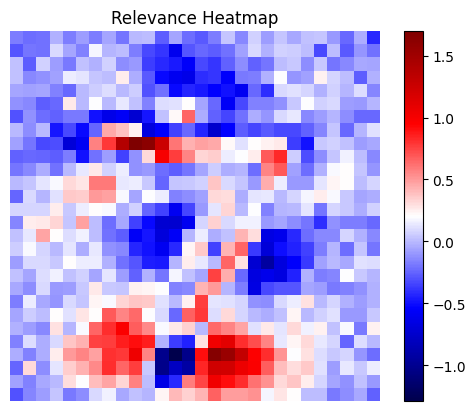

Applying custom heatmap: gray-red
saving image to  ../heatmap_0_gray-red.png


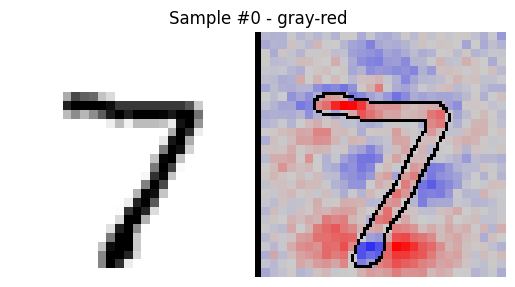

Applying custom heatmap: gray-red2
saving image to  ../heatmap_0_gray-red2.png


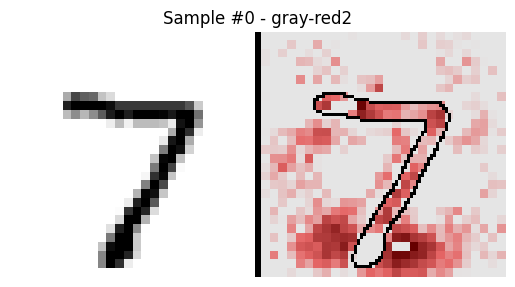

Applying custom heatmap: black-green
saving image to  ../heatmap_0_black-green.png


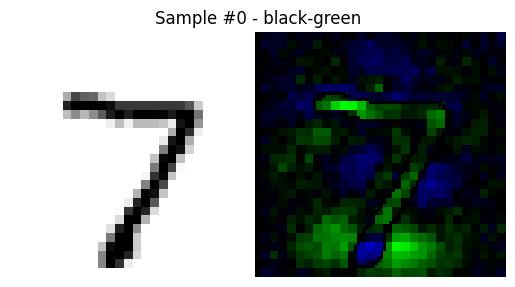

Applying custom heatmap: black-firered
saving image to  ../heatmap_0_black-firered.png


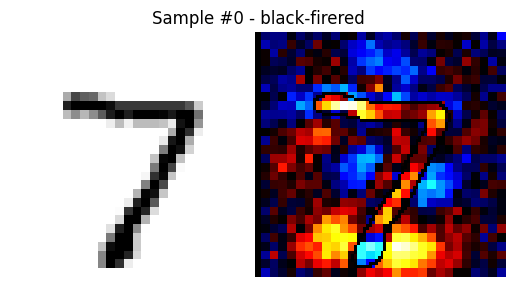

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_0_blue-black-yellow.png


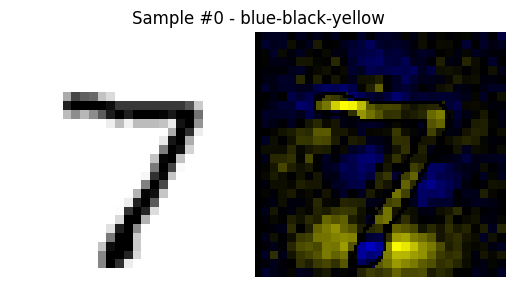

saving image to  ../heatmap_0.png
writing data in npy-format to ../heatmap.npy


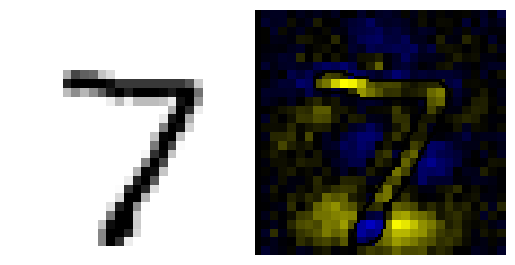

True Class:      2
Predicted Class: 2 



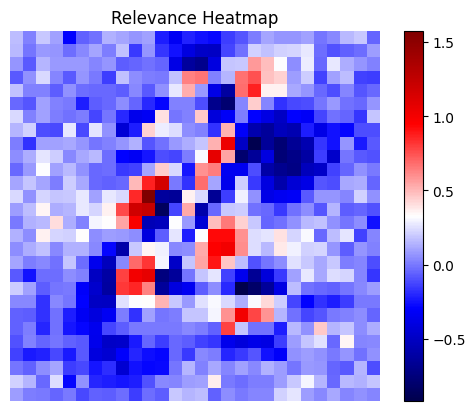

Applying custom heatmap: gray-red
saving image to  ../heatmap_1_gray-red.png


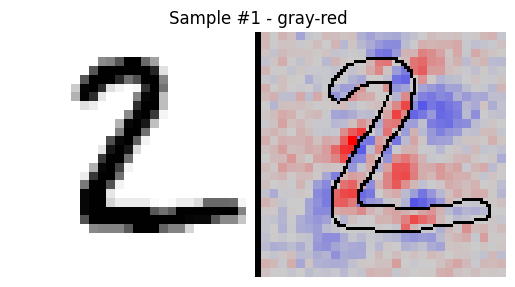

Applying custom heatmap: gray-red2
saving image to  ../heatmap_1_gray-red2.png


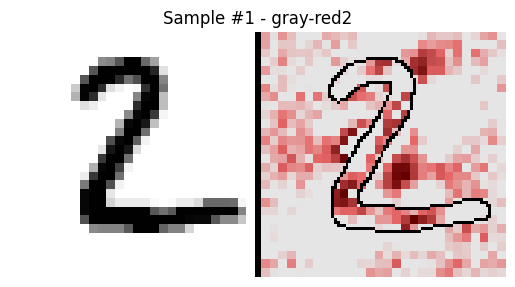

Applying custom heatmap: black-green
saving image to  ../heatmap_1_black-green.png


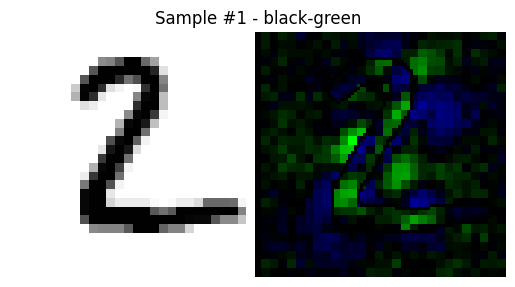

Applying custom heatmap: black-firered
saving image to  ../heatmap_1_black-firered.png


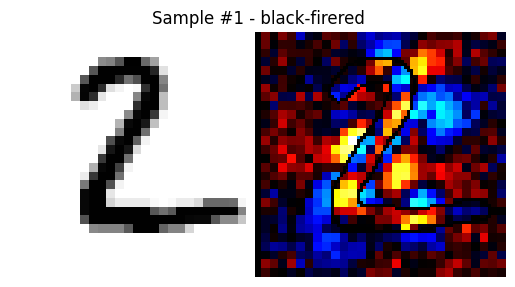

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_1_blue-black-yellow.png


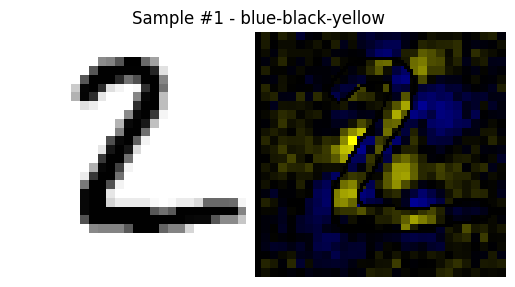

saving image to  ../heatmap_1.png
writing data in npy-format to ../heatmap.npy


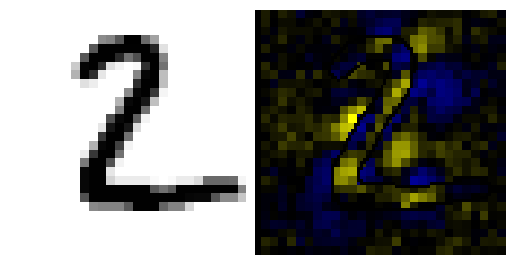

True Class:      1
Predicted Class: 1 



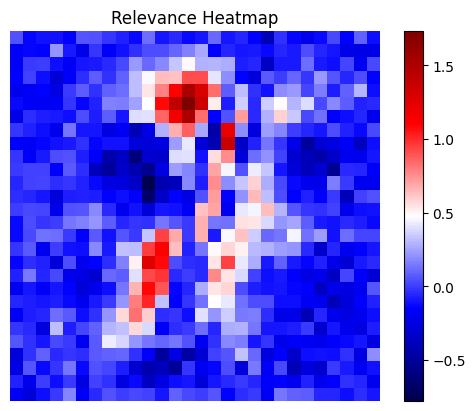

Applying custom heatmap: gray-red
saving image to  ../heatmap_2_gray-red.png


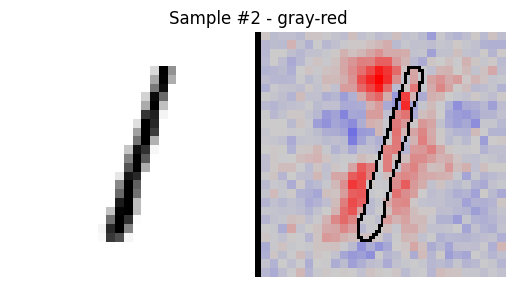

Applying custom heatmap: gray-red2
saving image to  ../heatmap_2_gray-red2.png


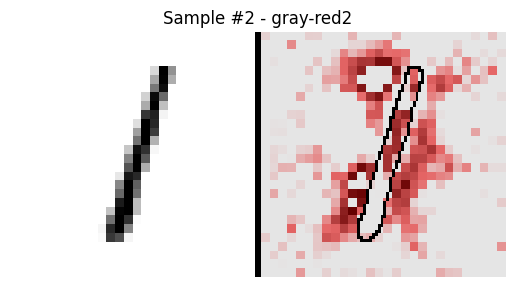

Applying custom heatmap: black-green
saving image to  ../heatmap_2_black-green.png


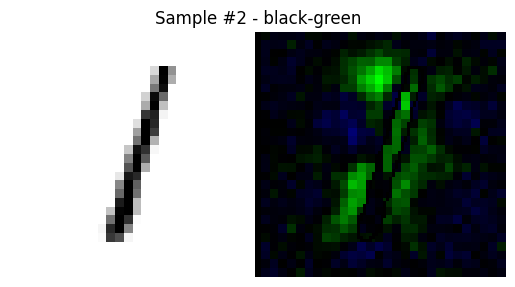

Applying custom heatmap: black-firered
saving image to  ../heatmap_2_black-firered.png


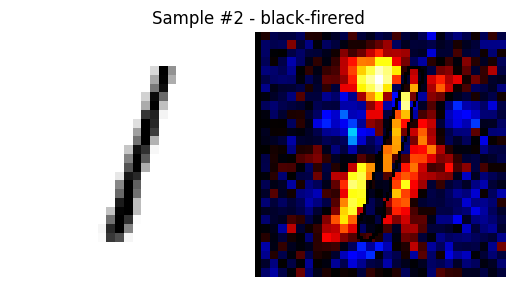

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_2_blue-black-yellow.png


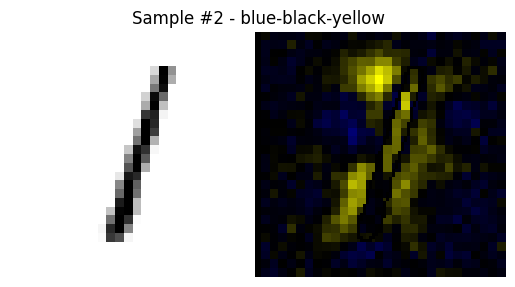

saving image to  ../heatmap_2.png
writing data in npy-format to ../heatmap.npy


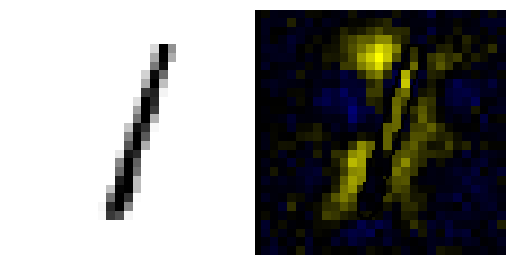

True Class:      0
Predicted Class: 0 



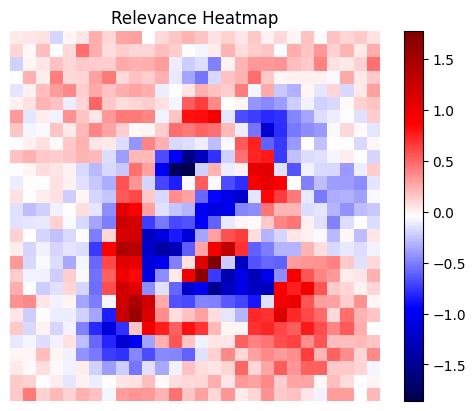

Applying custom heatmap: gray-red
saving image to  ../heatmap_3_gray-red.png


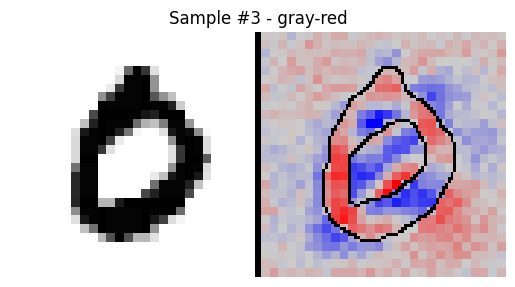

Applying custom heatmap: gray-red2
saving image to  ../heatmap_3_gray-red2.png


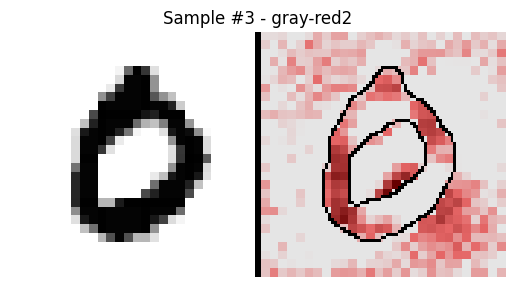

Applying custom heatmap: black-green
saving image to  ../heatmap_3_black-green.png


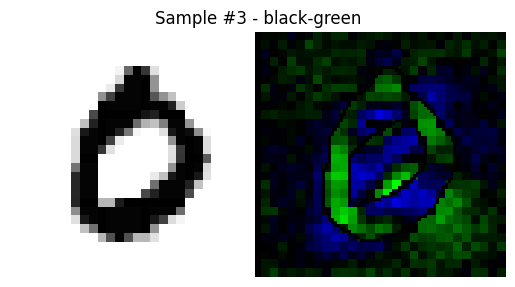

Applying custom heatmap: black-firered
saving image to  ../heatmap_3_black-firered.png


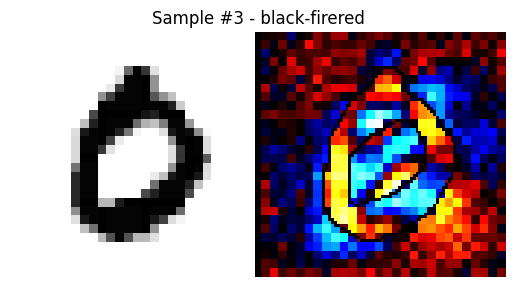

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_3_blue-black-yellow.png


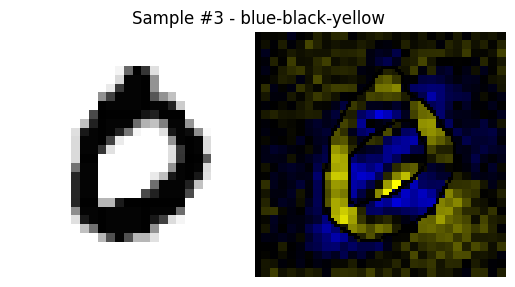

saving image to  ../heatmap_3.png
writing data in npy-format to ../heatmap.npy


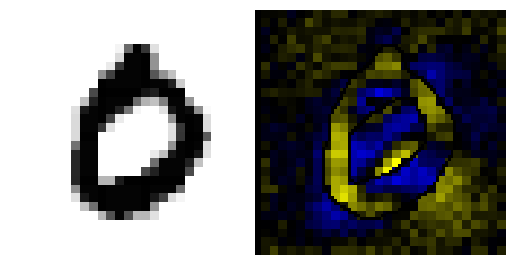

True Class:      4
Predicted Class: 4 



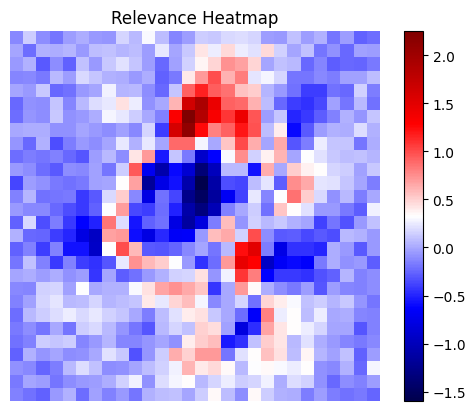

Applying custom heatmap: gray-red
saving image to  ../heatmap_4_gray-red.png


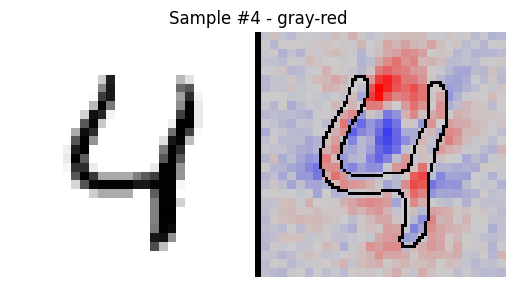

Applying custom heatmap: gray-red2
saving image to  ../heatmap_4_gray-red2.png


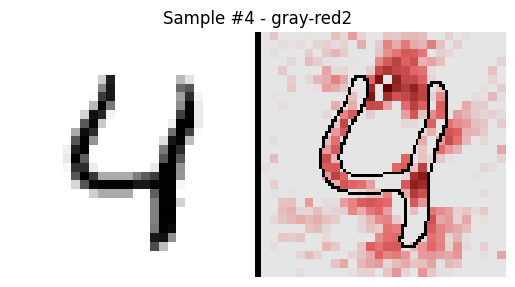

Applying custom heatmap: black-green
saving image to  ../heatmap_4_black-green.png


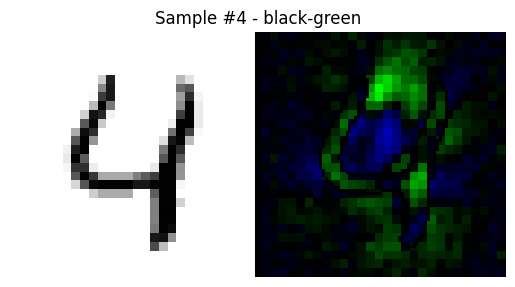

Applying custom heatmap: black-firered
saving image to  ../heatmap_4_black-firered.png


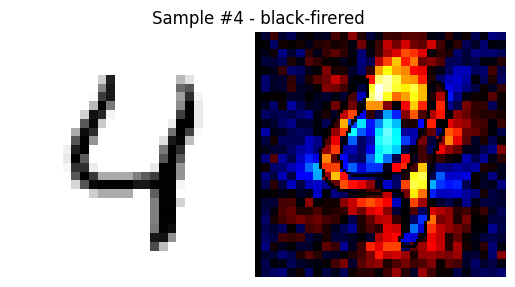

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_4_blue-black-yellow.png


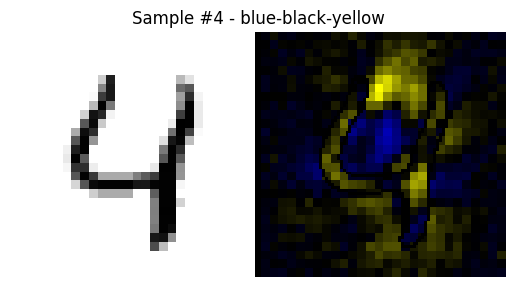

saving image to  ../heatmap_4.png
writing data in npy-format to ../heatmap.npy


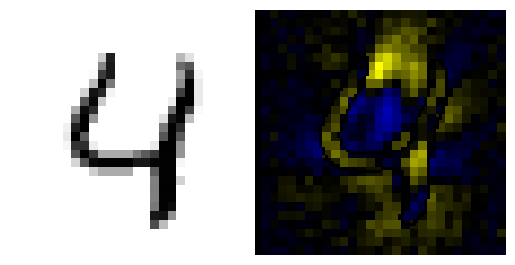

True Class:      1
Predicted Class: 1 



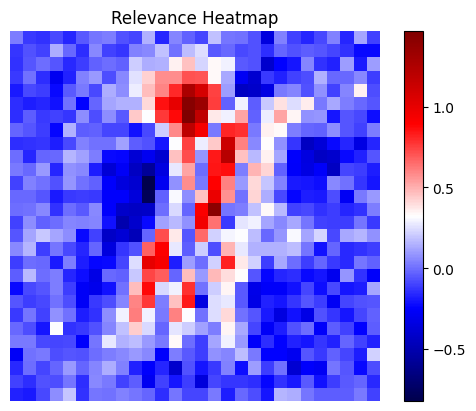

Applying custom heatmap: gray-red
saving image to  ../heatmap_5_gray-red.png


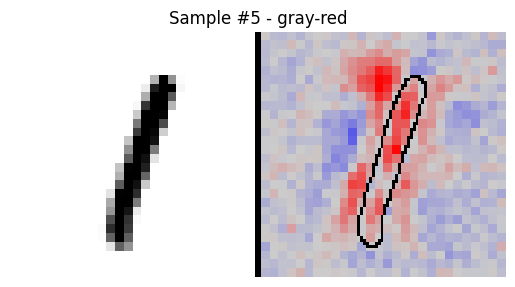

Applying custom heatmap: gray-red2
saving image to  ../heatmap_5_gray-red2.png


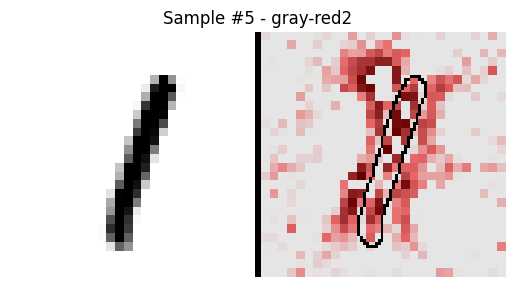

Applying custom heatmap: black-green
saving image to  ../heatmap_5_black-green.png


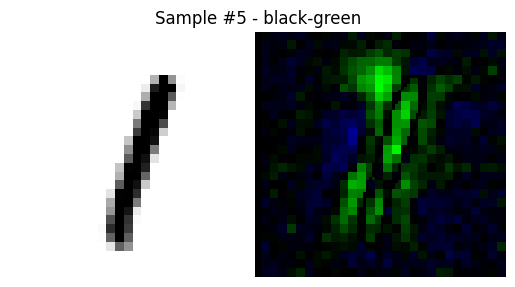

Applying custom heatmap: black-firered
saving image to  ../heatmap_5_black-firered.png


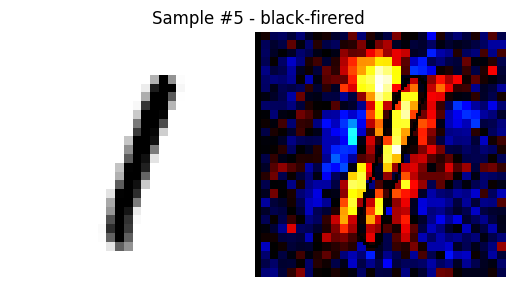

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_5_blue-black-yellow.png


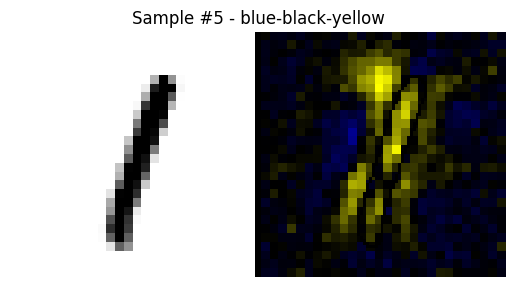

saving image to  ../heatmap_5.png
writing data in npy-format to ../heatmap.npy


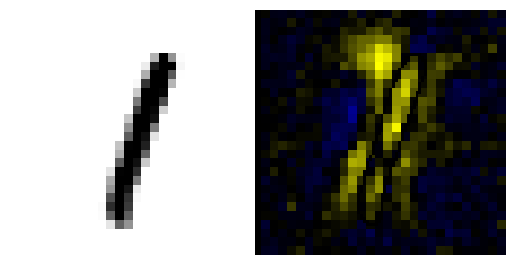

True Class:      4
Predicted Class: 4 



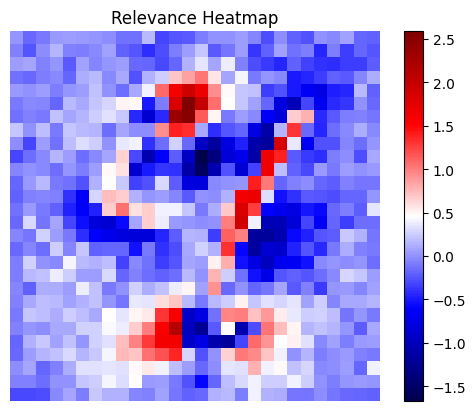

Applying custom heatmap: gray-red
saving image to  ../heatmap_6_gray-red.png


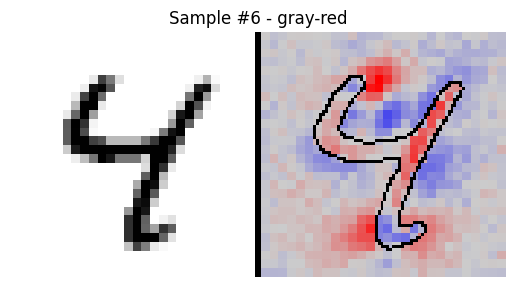

Applying custom heatmap: gray-red2
saving image to  ../heatmap_6_gray-red2.png


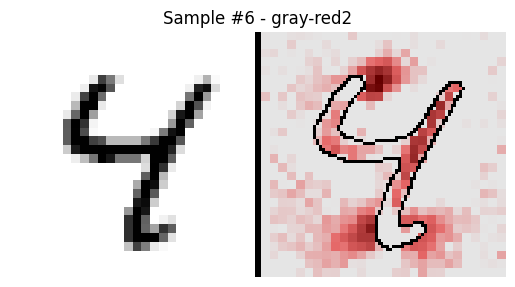

Applying custom heatmap: black-green
saving image to  ../heatmap_6_black-green.png


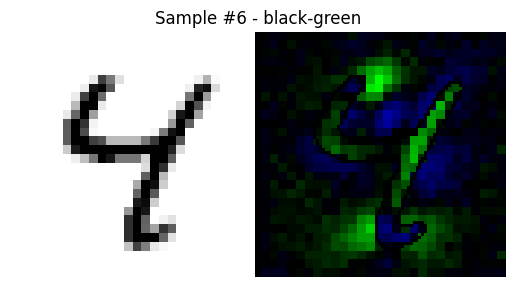

Applying custom heatmap: black-firered
saving image to  ../heatmap_6_black-firered.png


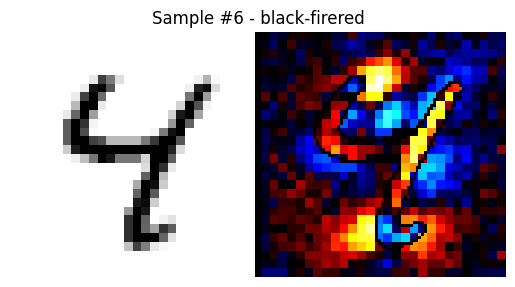

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_6_blue-black-yellow.png


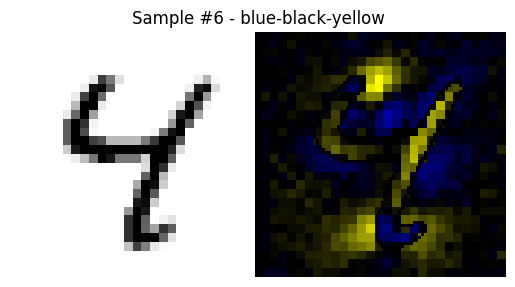

saving image to  ../heatmap_6.png
writing data in npy-format to ../heatmap.npy


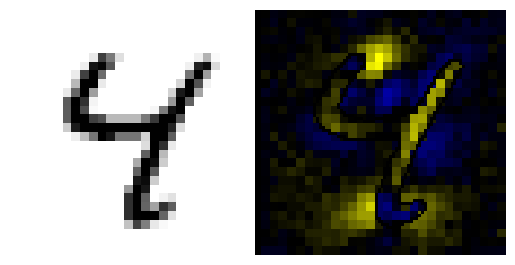

True Class:      9
Predicted Class: 9 



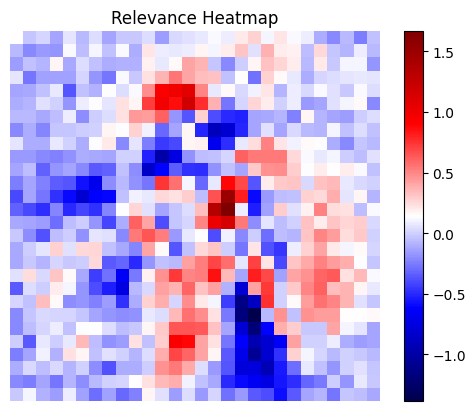

Applying custom heatmap: gray-red
saving image to  ../heatmap_7_gray-red.png


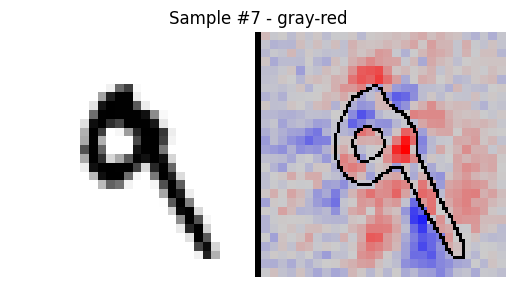

Applying custom heatmap: gray-red2
saving image to  ../heatmap_7_gray-red2.png


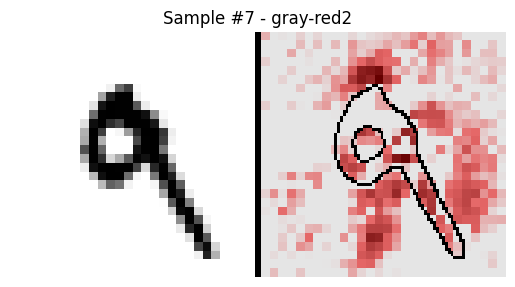

Applying custom heatmap: black-green
saving image to  ../heatmap_7_black-green.png


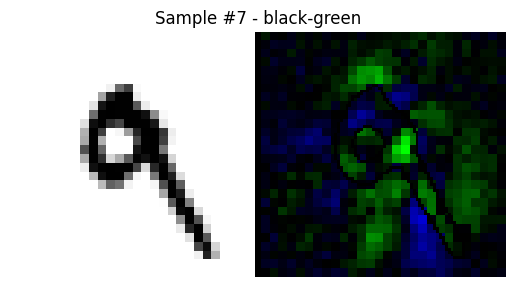

Applying custom heatmap: black-firered
saving image to  ../heatmap_7_black-firered.png


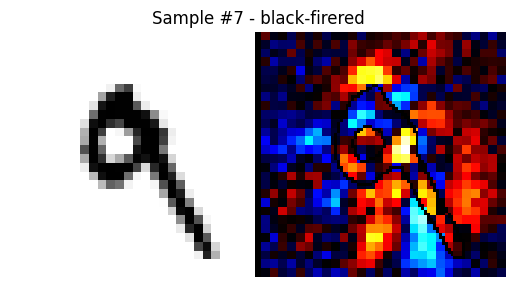

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_7_blue-black-yellow.png


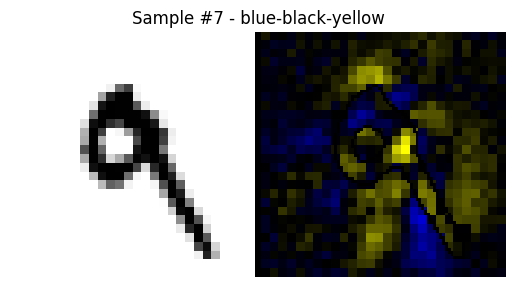

saving image to  ../heatmap_7.png
writing data in npy-format to ../heatmap.npy


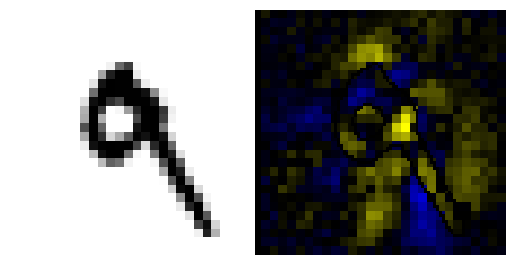

True Class:      5
Predicted Class: 5 



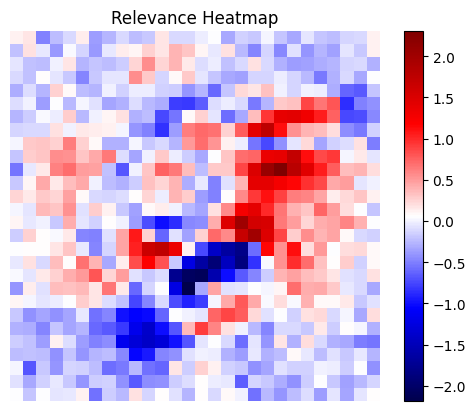

Applying custom heatmap: gray-red
saving image to  ../heatmap_8_gray-red.png


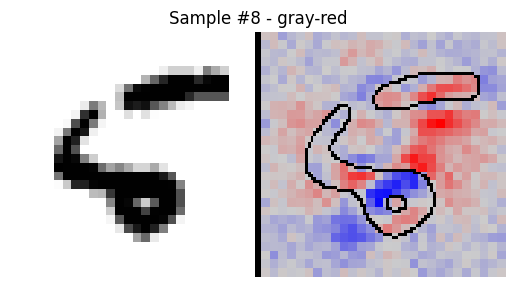

Applying custom heatmap: gray-red2
saving image to  ../heatmap_8_gray-red2.png


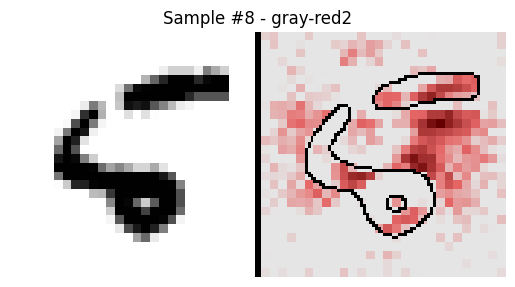

Applying custom heatmap: black-green
saving image to  ../heatmap_8_black-green.png


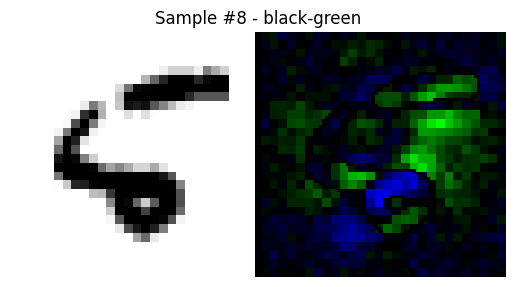

Applying custom heatmap: black-firered
saving image to  ../heatmap_8_black-firered.png


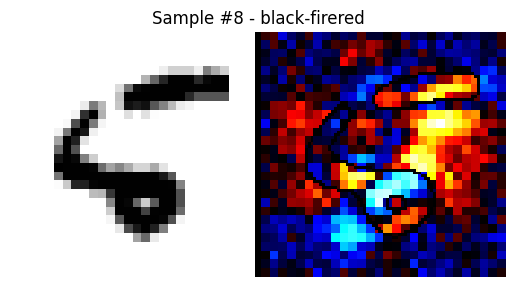

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_8_blue-black-yellow.png


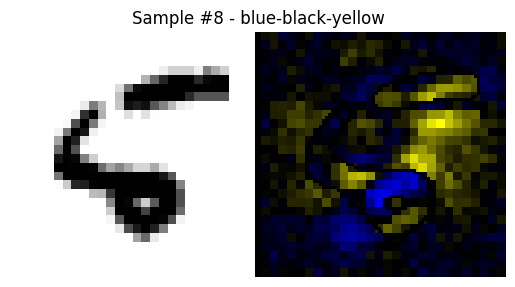

saving image to  ../heatmap_8.png
writing data in npy-format to ../heatmap.npy


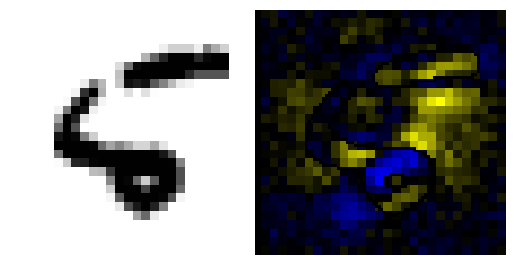

True Class:      9
Predicted Class: 9 



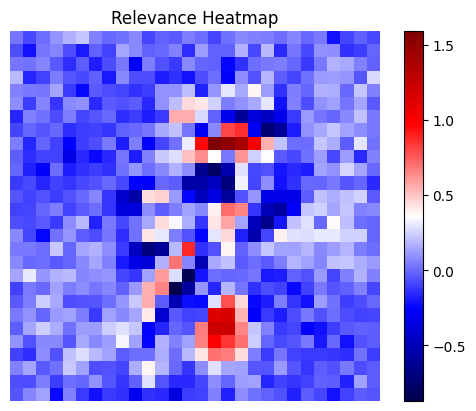

Applying custom heatmap: gray-red
saving image to  ../heatmap_9_gray-red.png


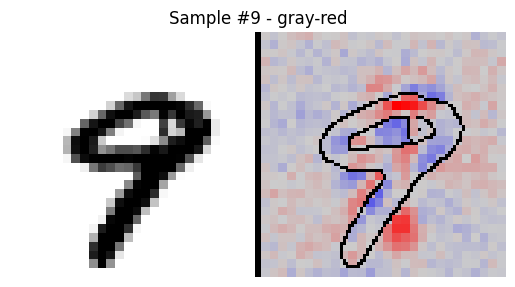

Applying custom heatmap: gray-red2
saving image to  ../heatmap_9_gray-red2.png


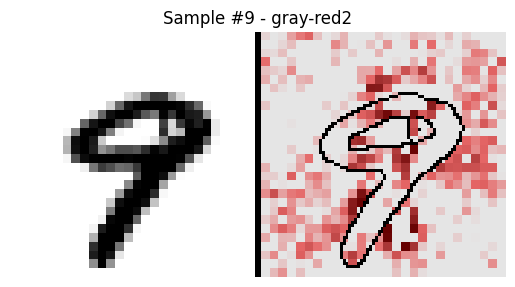

Applying custom heatmap: black-green
saving image to  ../heatmap_9_black-green.png


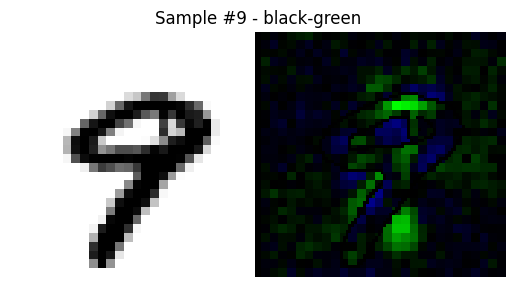

Applying custom heatmap: black-firered
saving image to  ../heatmap_9_black-firered.png


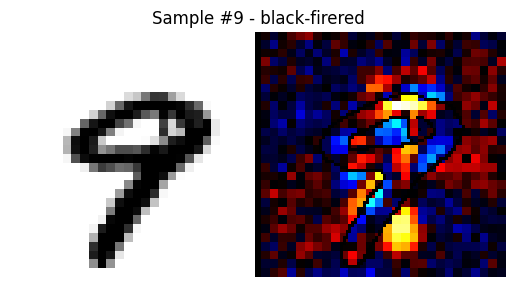

Applying custom heatmap: blue-black-yellow
saving image to  ../heatmap_9_blue-black-yellow.png


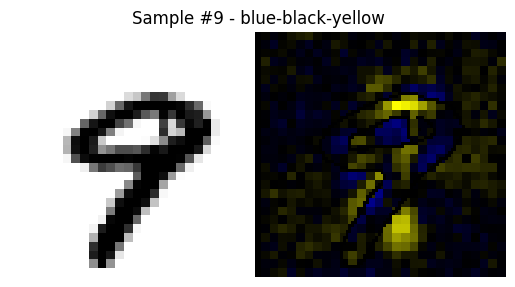

saving image to  ../heatmap_9.png
writing data in npy-format to ../heatmap.npy


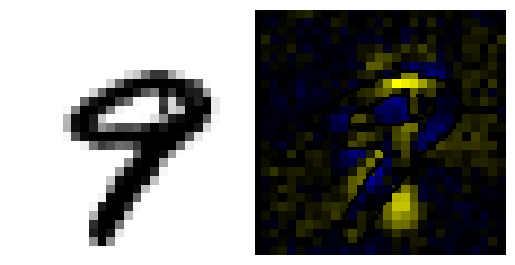

writing data in npy-format to ../Rbatch.npy
Computation of 256 heatmaps using cupy in 0.728s


In [7]:
  '''
  The purpose of this module is to demonstrate the process of obtaining pixel-wise explanations for given data points at hand of the MNIST hand written digit data set.

  The module first loads a pre-trained neural network model and the MNIST test set with labels and transforms the data such that each pixel value is within the range of [-1 1].
  The data is then randomly permuted and for the first 10 samples due to the permuted order, a prediction is computed by the network, which is then as a next step explained
  by attributing relevance values to each of the input pixels.

  finally, the resulting heatmap is rendered as an image and (over)written out to disk and displayed.

  LRP works by:

      Doing a standard forward pass on an input sample to make a prediction.

      Starting with the output prediction as total relevance, then propagating that relevance back layer by layer.

      At each layer, relevance is redistributed to the layer below based on specific rules (e.g., proportional to the contributions of neurons).

      Finally, each input feature gets a relevance score that tells you how much it contributed to the prediction
  '''


  import matplotlib.pyplot as plt
  import time
  import numpy
  import numpy as np
  import importlib.util as imp
  if imp.find_spec("cupy"): #use cupy for GPU support if available
      import cupy
      import cupy as np
  na = np.newaxis
  import render
  from skimage.transform import resize


  #load a neural network, as well as the MNIST test data and some labels
  nn = model_io.read('../models/MNIST/long-tanh.nn') # 99.16% prediction accuracy
  nn.drop_softmax_output_layer() #drop softnax output layer for analyses

  X = data_io.read('../data/MNIST/test_images.npy')
  Y = data_io.read('../data/MNIST/test_labels.npy')

  # transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
  X =  X / 127.5 - 1

  # transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
  I = Y[:,0].astype(int)
  Y = np.zeros([X.shape[0],np.unique(Y).size])
  Y[np.arange(Y.shape[0]),I] = 1

  acc = np.mean(np.argmax(nn.forward(X), axis=1) == np.argmax(Y, axis=1))
  if not np == numpy: # np=cupy
      acc = np.asnumpy(acc)
  print('model test accuracy is: {:0.4f}'.format(acc))

  #permute data order for demonstration. or not. your choice.
  I = np.arange(X.shape[0])
  #I = np.random.permutation(I)


  #predict and perform LRP for the 10 first samples
  for i in I[:10]:
      x = X[na,i,:]

      #forward pass and prediction
      ypred = nn.forward(x)
      print('True Class:     ', np.argmax(Y[i]))
      print('Predicted Class:', np.argmax(ypred),'\n')

      #prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
      mask = np.zeros_like(ypred)
      mask[:,np.argmax(ypred)] = 1
      Rinit = ypred*mask

      #compute first layer relevance according to prediction
      #R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
      R = nn.lrp(Rinit,'epsilon',0.01)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
      #R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140

      #R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
      '''
      yselect = 3
      yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
      R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
      '''

      #undo input normalization for digit drawing. get it back to range [0,1] per pixel
      x = (x+1.)/2.

      if not np == numpy: # np=cupy
          x = np.asnumpy(x)
          R = np.asnumpy(R)

      #render input and heatmap as rgb images
      digit = render.digit_to_rgb(x, scaling=3)


      # Similarly, reshape the relevance map if it's flattened (1D array)
      R_numpy = R.reshape(28, 28)

      # Display the relevance map as a heatmap
      plt.imshow(R_numpy, cmap='seismic', interpolation='none')
      plt.colorbar()  # Show color bar to indicate relevance magnitude
      plt.title("Relevance Heatmap")
      plt.axis('off')
      plt.show()

      # Loop through all custom heatmaps
      for cmap_name in render.custom_maps.keys():
          print(f'Applying custom heatmap: {cmap_name}')
          hm = render.hm_to_rgb(R, X=x, scaling=3, cmap=cmap_name, sigma=2)
          digit_hm = render.save_image([digit, hm], f'../heatmap_{i}_{cmap_name}.png')

          # Display (optional)
          plt.imshow(digit_hm, interpolation='none')
          plt.title(f'Sample #{i} - {cmap_name}')
          plt.axis('off')
          plt.show()

      digit_hm = render.save_image([digit, hm], f'../heatmap_{i}.png')
      data_io.write(R,'../heatmap.npy')

      #display the image as written to file
      plt.imshow(digit_hm, interpolation = 'none')
      plt.axis('off')
      plt.show()


  #note that modules.Sequential allows for batch processing inputs
  if True:
      N = 256
      t_start = time.time()
      x = X[:N,...]
      y = nn.forward(x)
      R = nn.lrp(y)
      data_io.write(R,'../Rbatch.npy')
      print('Computation of {} heatmaps using {} in {:.3f}s'.format(N, np.__name__, time.time() - t_start))



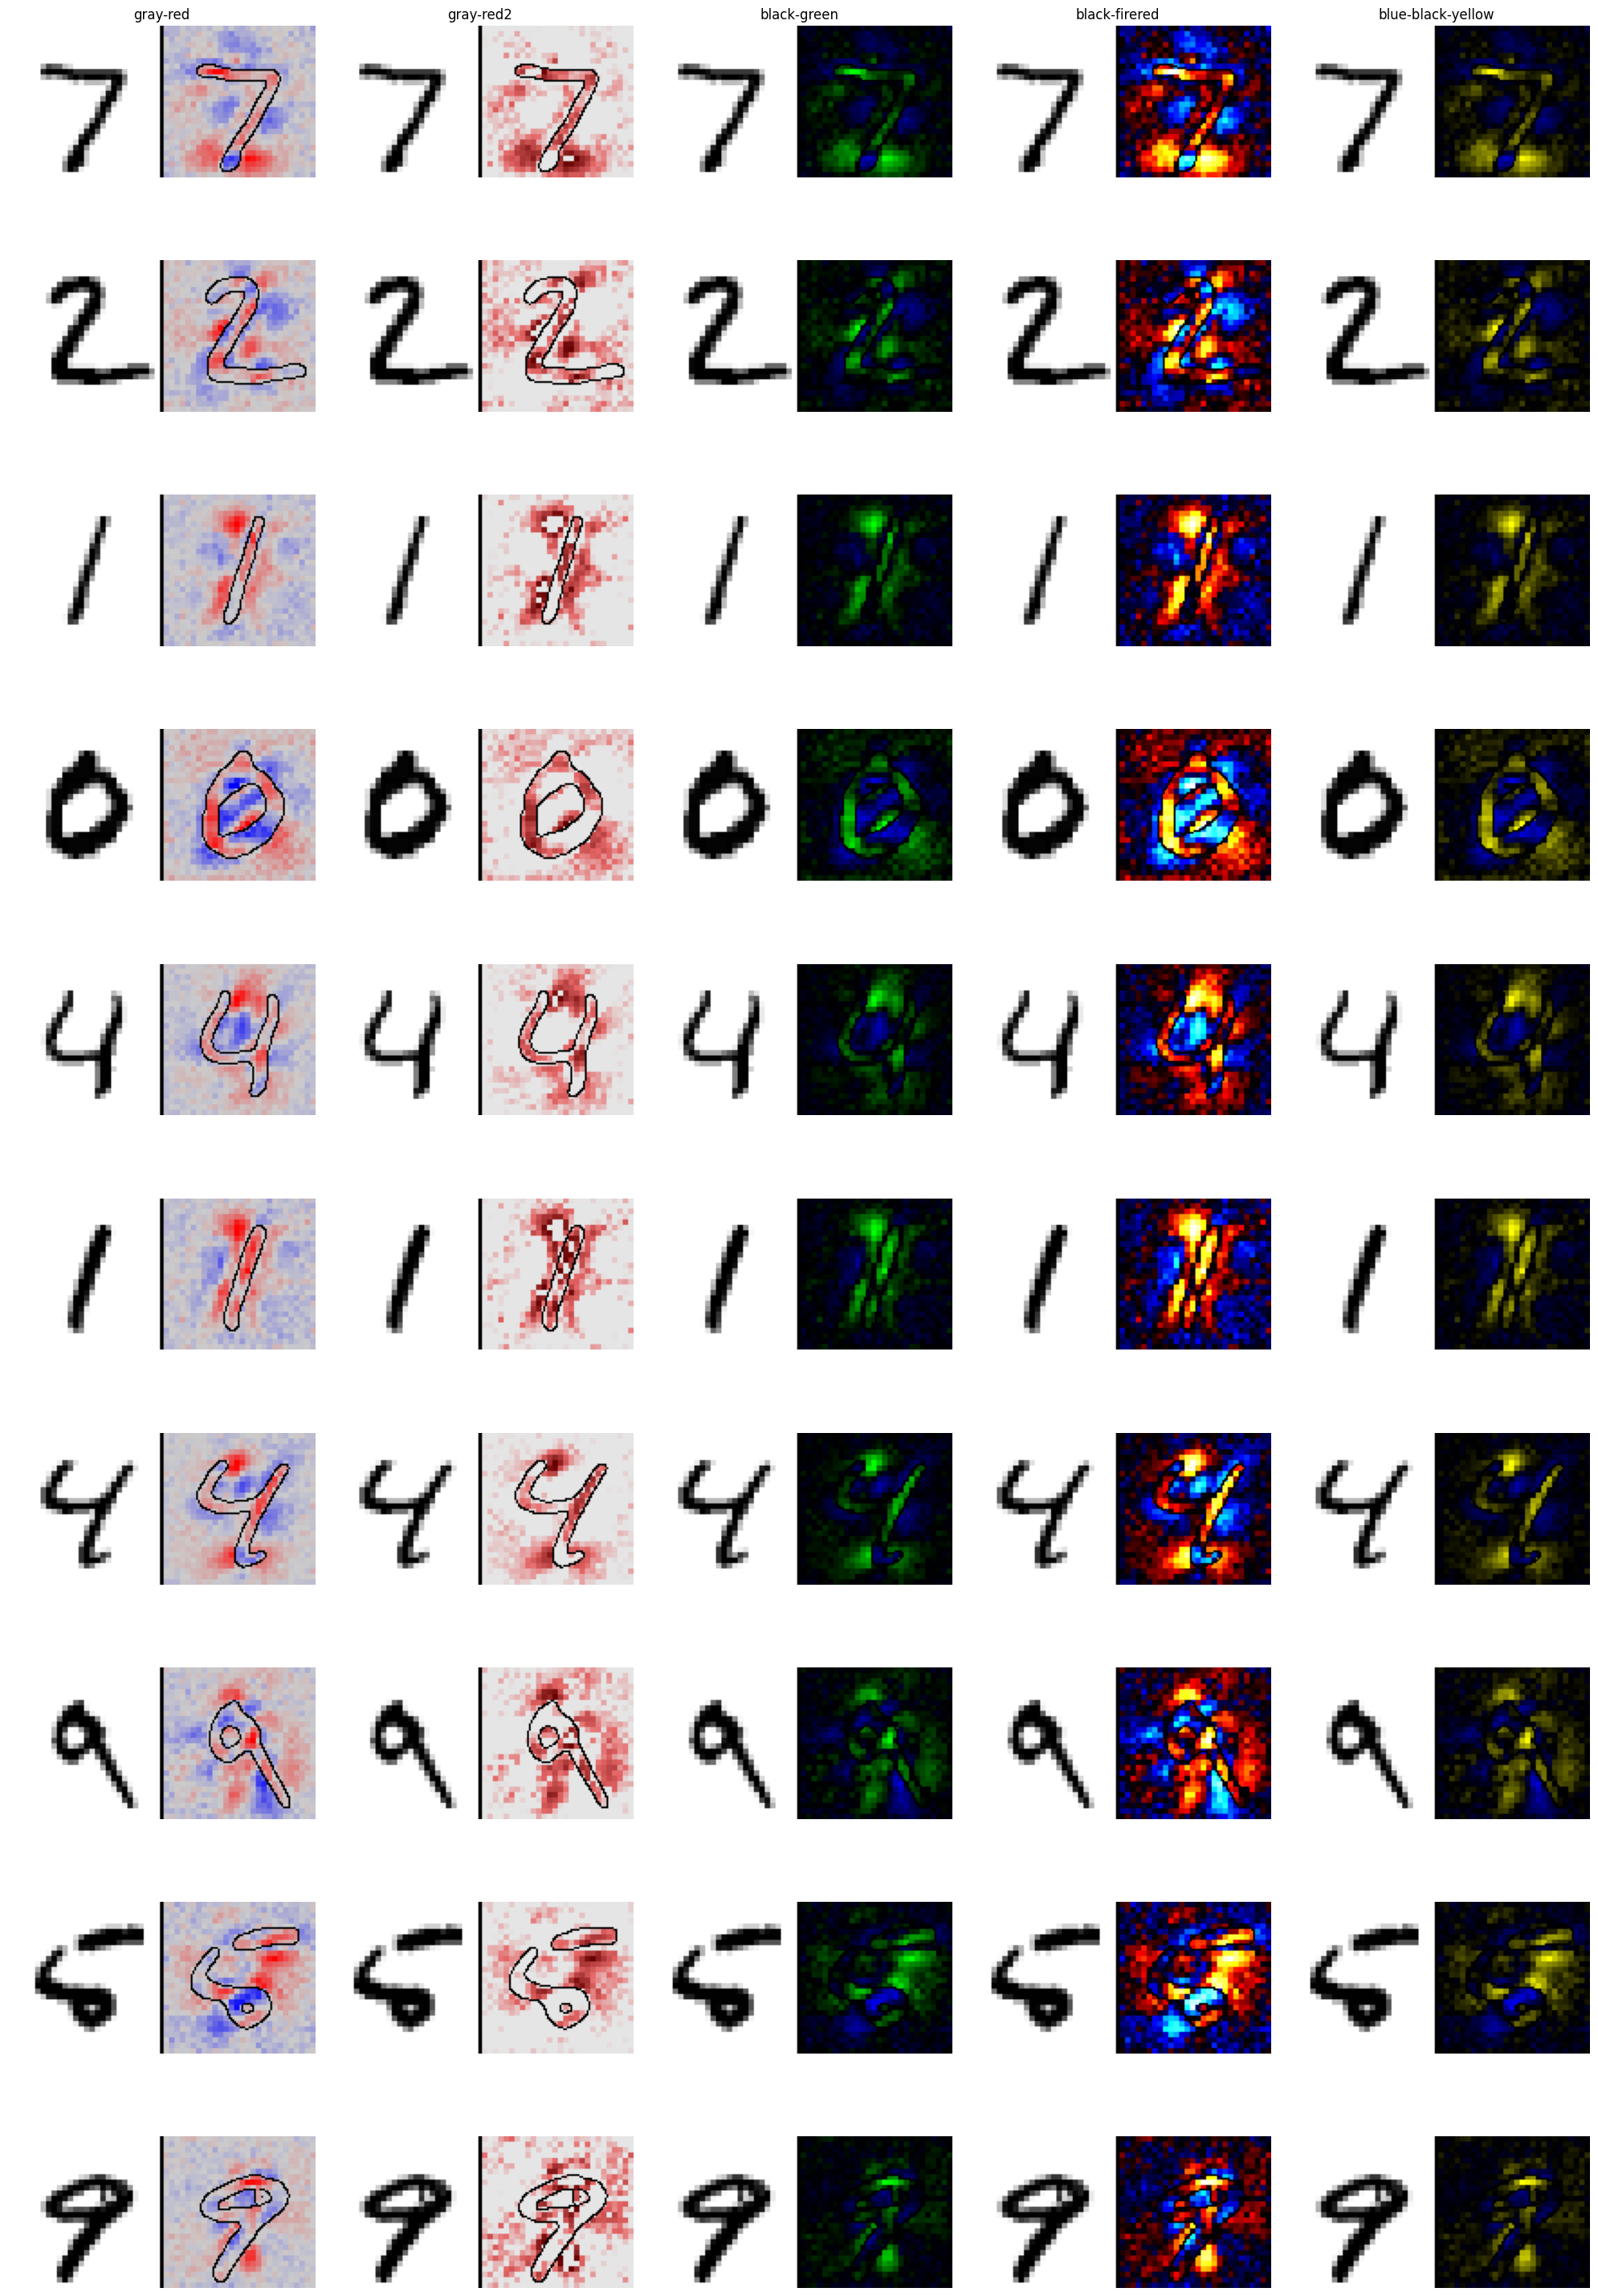

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the folder where heatmaps were saved
base_path = '../'  # adjust if needed

num_samples = 10
cmap_names = [
    'gray-red', 'gray-red2', 'black-green', 'black-firered', 'blue-black-yellow'
]  # Same as keys in render.custom_maps

# Set up a figure grid: rows = samples, columns = colormaps
fig, axes = plt.subplots(num_samples, len(cmap_names), figsize=(4 * len(cmap_names), 3 * num_samples))

for i in range(num_samples):
    for j, cmap in enumerate(cmap_names):
        img_path = os.path.join(base_path, f'heatmap_{i}_{cmap}.png')
        img = mpimg.imread(img_path)

        ax = axes[i, j] if num_samples > 1 else axes[j]
        ax.imshow(img)
        ax.axis('off')
        if i == 0:
            ax.set_title(cmap)

plt.tight_layout()
plt.show()


##Timing MNIST


In [9]:
'''

compute execution times for different lrp computation variants, from naive to optimized.
'''

import time
import matplotlib.pyplot as plt
import importlib.util as imp
import numpy
import numpy as np
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis




#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read('../models/MNIST/long-rect.nn') # 99.17% prediction accuracy
X = data_io.read('../data/MNIST/test_images.npy')
Y = data_io.read('../data/MNIST/test_labels.npy')

# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y[:,0].astype(int)
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

#permute data order for demonstration. or not. your choice.
I = np.arange(X.shape[0])


# do some benchmarking.
def benchmark():
    for B in [1 ,16, 64]: #batch sizes for work laptop with only 8GB RAM
    #for B in [1, 16, 64, 256]:

        forward_times_old = []
        forward_times_new = []
        forward_times_aware = []

        lrp_times_old = []  #simple
        lrp_times_old2 = [] #epsilon
        lrp_times_old3 = [] #alpha 2, beta -1
        lrp_times_old4 = [] #alpha 1, beta 0
        lrp_times_old5 = [] #alpha 0, beta 1

        lrp_times_new = []  #s
        lrp_times_new2 = [] #e
        lrp_times_new3 = [] #a2b-1
        lrp_times_new4 = [] #a1b0
        lrp_times_new5 = [] #a0b1

        lrp_times_aware = []  #s
        lrp_times_aware2 = [] #e
        lrp_times_aware3 = [] #a2b-1
        lrp_times_aware4 = [] #a1b0
        lrp_times_aware5 = [] #a0b1


        print('#####################################')
        print('Measuring Speed Gain for batch of {} on FCNN using {}'.format(B, np.__name__))
        print('#####################################')
        for i in range(10):
            x = X[:B,:]
            # old code
            t_start = time.time();  yold = nn.forward(x);                               forward_times_old.append(time.time() - t_start)
            t_start = time.time();  Rold = nn.lrp(yold, 'simple_slow');                 lrp_times_old.append(time.time() - t_start)
            t_start = time.time();  REold = nn.lrp(yold, 'epsilon_slow', 0.01);         lrp_times_old2.append(time.time() - t_start)
            t_start = time.time();  RAold2 = nn.lrp(yold, 'alphabeta_slow', 2.);          lrp_times_old3.append(time.time() - t_start)
            t_start = time.time();  RAold1 = nn.lrp(yold, 'alphabeta_slow', 1.);          lrp_times_old4.append(time.time() - t_start)
            t_start = time.time();  RAold0 = nn.lrp(yold, 'alphabeta_slow', 0.);          lrp_times_old5.append(time.time() - t_start)
            # newer lrp code
            t_start = time.time();  ynew = nn.forward(x);                               forward_times_new.append(time.time() - t_start)
            t_start = time.time();  Rnew = nn.lrp(ynew, 'simple');                      lrp_times_new.append(time.time() - t_start)
            t_start = time.time();  REnew = nn.lrp(ynew, 'epsilon', 0.01);              lrp_times_new2.append(time.time() - t_start)
            t_start = time.time();  RAnew2 = nn.lrp(ynew, 'alphabeta', 2.);              lrp_times_new3.append(time.time() - t_start)
            t_start = time.time();  RAnew1 = nn.lrp(ynew, 'alphabeta', 1.);              lrp_times_new4.append(time.time() - t_start)
            t_start = time.time();  RAnew0 = nn.lrp(ynew, 'alphabeta', 0.);              lrp_times_new5.append(time.time() - t_start)

            # lrp aware code and forward pass
            t_start = time.time();  yaw = nn.forward(x, lrp_aware=True);                forward_times_aware.append(time.time() - t_start)
            t_start = time.time();  Raw = nn.lrp(yaw, 'simple');                        lrp_times_aware.append(time.time() - t_start)
            t_start = time.time();  REaw= nn.lrp(yaw, 'epsilon', 0.01);                 lrp_times_aware2.append(time.time() - t_start)
            t_start = time.time();  RAaw2= nn.lrp(yaw, 'alphabeta', 2.);                 lrp_times_aware3.append(time.time() - t_start)
            t_start = time.time();  RAaw1= nn.lrp(yaw, 'alphabeta', 1.);                 lrp_times_aware4.append(time.time() - t_start)
            t_start = time.time();  RAaw0= nn.lrp(yaw, 'alphabeta', 0.);                 lrp_times_aware5.append(time.time() - t_start)

            tolerance = 1e-8
            np.testing.assert_allclose(yold, ynew, rtol=tolerance) # predictions
            np.testing.assert_allclose(yold, yaw, rtol=tolerance)

            np.testing.assert_allclose(Rold, Rnew, rtol=tolerance) # simple lrp maps
            np.testing.assert_allclose(Rold, Raw, rtol=tolerance)

            np.testing.assert_allclose(REold, REnew, rtol=tolerance) # eps lrp maps
            np.testing.assert_allclose(REold, REaw, rtol=tolerance)

            np.testing.assert_allclose(RAold2, RAnew2, rtol=tolerance) # alpha2 lrp maps
            np.testing.assert_allclose(RAold2, RAaw2, rtol=tolerance)

            np.testing.assert_allclose(RAold1, RAnew1, rtol=tolerance) # alpha1 lrp maps
            np.testing.assert_allclose(RAold1, RAaw1, rtol=tolerance)

            np.testing.assert_allclose(RAold0, RAnew0, rtol=tolerance) # alpha0 lrp maps
            np.testing.assert_allclose(RAold0, RAaw0, rtol=tolerance)

            print('.',end='')

        print()
        print('    Mean Forward pass times:')
        print('      old:  ', numpy.mean(forward_times_old), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(forward_times_old)/numpy.mean(forward_times_old)))))
        print('      new:  ', numpy.mean(forward_times_new), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(forward_times_new)/numpy.mean(forward_times_old)))))
        print('      aware:', numpy.mean(forward_times_aware), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(forward_times_aware)/numpy.mean(forward_times_old)))))
        print('    Mean LRP times 1 (simple lrp):')
        print('      old:  ', numpy.mean(lrp_times_old), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_old)/numpy.mean(lrp_times_old)))))
        print('      new:  ', numpy.mean(lrp_times_new), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_new)/numpy.mean(lrp_times_old)))))
        print('      aware:', numpy.mean(lrp_times_aware), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_aware)/numpy.mean(lrp_times_old)))))
        print('    Mean LRP times 2 (epsilon lrp):')
        print('      old:  ', numpy.mean(lrp_times_old2), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_old2)/numpy.mean(lrp_times_old2)))))
        print('      new:  ', numpy.mean(lrp_times_new2), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_new2)/numpy.mean(lrp_times_old2)))))
        print('      aware:', numpy.mean(lrp_times_aware2), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_aware2)/numpy.mean(lrp_times_old2)))))
        print('    Mean LRP times 3 (alpha=2 lrp):')
        print('      old:  ', numpy.mean(lrp_times_old3), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_old3)/numpy.mean(lrp_times_old3)))))
        print('      new:  ', numpy.mean(lrp_times_new3), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_new3)/numpy.mean(lrp_times_old3)))))
        print('      aware:', numpy.mean(lrp_times_aware3), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_aware3)/numpy.mean(lrp_times_old3)))))
        print('    Mean LRP times 4 (alpha=1 lrp):')
        print('      old:  ', numpy.mean(lrp_times_old4), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_old4)/numpy.mean(lrp_times_old4)))))
        print('      new:  ', numpy.mean(lrp_times_new4), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_new4)/numpy.mean(lrp_times_old4)))))
        print('      aware:', numpy.mean(lrp_times_aware4), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_aware4)/numpy.mean(lrp_times_old4)))))
        print('    Mean LRP times 5 (alpha=0 lrp):')
        print('      old:  ', numpy.mean(lrp_times_old5), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_old5)/numpy.mean(lrp_times_old5)))))
        print('      new:  ', numpy.mean(lrp_times_new5), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_new5)/numpy.mean(lrp_times_old5)))))
        print('      aware:', numpy.mean(lrp_times_aware5), '({}% speedup vs old)'.format(int(100*(1 - numpy.mean(lrp_times_aware5)/numpy.mean(lrp_times_old5)))))
        print('    Mean Total times with LRP once:')
        oldtotal = numpy.mean(numpy.array(lrp_times_old) + numpy.array(forward_times_old))
        newtotal = numpy.mean(numpy.array(lrp_times_new) + numpy.array(forward_times_new))
        awaretotal = numpy.mean(numpy.array(lrp_times_aware) + numpy.array(forward_times_aware))
        print('      old:  ', oldtotal, '({}% speedup vs old)'.format(int(100*(1 - oldtotal/oldtotal))))
        print('      new:  ', newtotal, '({}% speedup vs old)'.format(int(100*(1 - newtotal/oldtotal))))
        print('      aware:', awaretotal, '({}% speedup vs old)'.format(int(100*(1 - awaretotal/oldtotal))))
        print('    Mean Total times with LRP twice (simple+epsilon):')
        oldtotaltwice = numpy.mean(numpy.array(lrp_times_old) + numpy.array(lrp_times_old2) + numpy.array(forward_times_old))
        newtotaltwice = numpy.mean(numpy.array(lrp_times_new) + numpy.array(lrp_times_new2) + numpy.array(forward_times_new))
        awaretotaltwice = numpy.mean(numpy.array(lrp_times_aware) + numpy.array(lrp_times_aware2) + numpy.array(forward_times_aware))
        print('      old:  ', oldtotaltwice, '({}% speedup vs old)'.format(int(100*(1 - oldtotaltwice/oldtotaltwice))))
        print('      new:  ', newtotaltwice, '({}% speedup vs old)'.format(int(100*(1 - newtotaltwice/oldtotaltwice))))
        print('      aware:', awaretotaltwice, '({}% speedup vs old)'.format(int(100*(1 - awaretotaltwice/oldtotaltwice))))
        print('    Mean Total times with LRP five times(simple,epsilon,alpha=2,alpha=1,alpha=0):')
        oldtotalfive = oldtotaltwice + numpy.mean(numpy.array(lrp_times_old3) + numpy.array(lrp_times_old4) + numpy.array(lrp_times_old5))
        newtotalfive = newtotaltwice +  numpy.mean(numpy.array(lrp_times_new3) + numpy.array(lrp_times_new4) + numpy.array(lrp_times_new5))
        awaretotalfive = awaretotaltwice +  numpy.mean(numpy.array(lrp_times_aware3) + numpy.array(lrp_times_aware4) + numpy.array(lrp_times_aware5))
        print('      old:  ', oldtotalfive, '({}% speedup vs old)'.format(int(100*(1 - oldtotalfive/oldtotalfive))))
        print('      new:  ', newtotalfive, '({}% speedup vs old)'.format(int(100*(1 - newtotalfive/oldtotalfive))))
        print('      aware:', awaretotalfive, '({}% speedup vs old)'.format(int(100*(1 - awaretotalfive/oldtotalfive))))
        print('')
        print('')

#run benchmark
benchmark()


loading pickled model from ../models/MNIST/long-rect.nn
loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy
#####################################
Measuring Speed Gain for batch of 1 on FCNN using cupy
#####################################


/usr/local/lib/python3.11/dist-packages/cupy/_io/npz.py:64: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  obj = numpy.load(file, mmap_mode, allow_pickle)


..........
    Mean Forward pass times:
      old:   0.0006105661392211914 (0% speedup vs old)
      new:   0.000465703010559082 (23% speedup vs old)
      aware: 0.0006150245666503906 (0% speedup vs old)
    Mean LRP times 1 (simple lrp):
      old:   0.0016611814498901367 (0% speedup vs old)
      new:   0.0013051748275756836 (21% speedup vs old)
      aware: 0.0010341882705688476 (37% speedup vs old)
    Mean LRP times 2 (epsilon lrp):
      old:   0.001567983627319336 (0% speedup vs old)
      new:   0.001233983039855957 (21% speedup vs old)
      aware: 0.0010130882263183593 (35% speedup vs old)
    Mean LRP times 3 (alpha=2 lrp):
      old:   0.012185406684875489 (0% speedup vs old)
      new:   0.002652478218078613 (78% speedup vs old)
      aware: 0.00269775390625 (77% speedup vs old)
    Mean LRP times 4 (alpha=1 lrp):
      old:   0.001732039451599121 (0% speedup vs old)
      new:   0.0015344858169555665 (11% speedup vs old)
      aware: 0.0014789581298828125 (14% speedup vs

##Mini

loading pickled model from ../models/MNIST/long-rect.nn
loading np-formatted data from ../data/MNIST/test_images.npy
saving image to  ../hm_py.png


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 24, 255, 221],
        [ 24, 255, 221],
        [ 24, 255, 221]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 24, 255, 221],
        [ 24, 255, 221],
        [ 24, 255, 221]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 24, 255, 221],
        [ 24, 255, 221],
        [ 24, 255, 221]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [112, 255, 134],
        [112, 255, 134],
        [112, 255, 134]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [112, 255, 134],
        [112, 255, 134],
        [112, 255, 134]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [112, 255, 134],
        [112, 255, 134],
        [112, 255, 134]]], dtype=uint8)
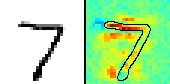

In [10]:



# imports
import model_io
import data_io
import render

import importlib.util as imp
import numpy
import numpy as np
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis
# end of imports

nn = model_io.read('../models/MNIST/long-rect.nn') # read model
X = data_io.read('../data/MNIST/test_images.npy')[na,0,:] # load first MNIST test image
X = X / 127.5 - 1 # normalized data to range [-1 1]

Ypred = nn.forward(X) # forward pass through network
R = nn.lrp(Ypred) # lrp to explain prediction of X

if not np == numpy: # np=cupy
        X = np.asnumpy(X)
        R = np.asnumpy(R)

# render rgb images and save as image
digit = render.digit_to_rgb(X)
hm = render.hm_to_rgb(R, X) # render heatmap R, use X as outline
render.save_image([digit, hm], '../hm_py.png')
